## Binary Classification

The plan is to perform binary classification task of detecting an elephant in the images. Following models will be used for the task and accuracy will be computed on each of the following models:

1. VGG16
2. VGG19
3. Resnet50

Models are pretrained on imagenet dataset

In [1]:
#Ignore warnings
import warnings

from torch.utils.data import DataLoader, Dataset

#import data_utils

warnings.filterwarnings ( "ignore" )

from torchvision import transforms, datasets
import glob
import os
import numpy as np
import ntpath
from skimage import io

import torch
import torchvision
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
from torchvision import models
from IPython import display

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


%matplotlib inline

## Decode imagenet labels for predictions

In [2]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'


In [3]:
elephant_labels = ['Indian_elephant','African_elephant']
def decode_predictions(preds):
    global CLASS_INDEX
    ## preds are 2d
    assert len(preds.shape) == 2 and preds.shape[1]==1000
    
    ## If indx is none
    if CLASS_INDEX is None:
        fpath = "../data/imagenet_class_index.json"
        idx2label = []
        cls2label = {}
        with open(fpath, "r") as read_file:
            CLASS_INDEX = json.load(read_file)
            idx2label = [class_idx[str(k)][1] for k in range(len(CLASS_INDEX))]
            cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(CLASS_INDEX))}

    indices = preds.max(1, keepdim=True)[1]  ## index of max probability  
    results = []
    print(indices)
    print(idx2label)
    
    for i in indices:
        label = idx2label[str(i)]
        print(label)
        if label in elephant_labels:
            results.append(1)
        else:
            results.append(0)
    return results
    
    

## Custom Dataloader
        

In [4]:
input_size = 224

class BinaryClassifierDataset(Dataset):
    """Binary classifier dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with imagenames.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_path_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_path_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        pil2tensor = transforms.ToTensor()
        
        img_name = os.path.join(self.root_dir,self.image_path_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        if self.transform:
            image = self.transform(image)
        ## image, label
        
        return image.numpy(), torch.tensor(1)
    


In [5]:
data_transforms = transforms.Compose ( [
    transforms.ToPILImage(), # because the input dtype is numpy.ndarray
    transforms.Resize ( input_size ),
    transforms.CenterCrop ( input_size ),
    transforms.ToTensor(),
    transforms.Normalize ( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )
    ] )

elephant_dataset = BinaryClassifierDataset(csv_file='../data/binary-classifier/binary_classifier_imagepaths.csv',
                                    root_dir='../data/binary-classifier/', transform=data_transforms)



In [6]:
## dataloader
batch_size = 1
test_dataloader = torch.utils.data.DataLoader (elephant_dataset, batch_size=batch_size,shuffle=False, num_workers=8,pin_memory=True )
    

### Test data loader

In [7]:
print(f"No of images: {len(test_dataloader)}")


No of images: 19433


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


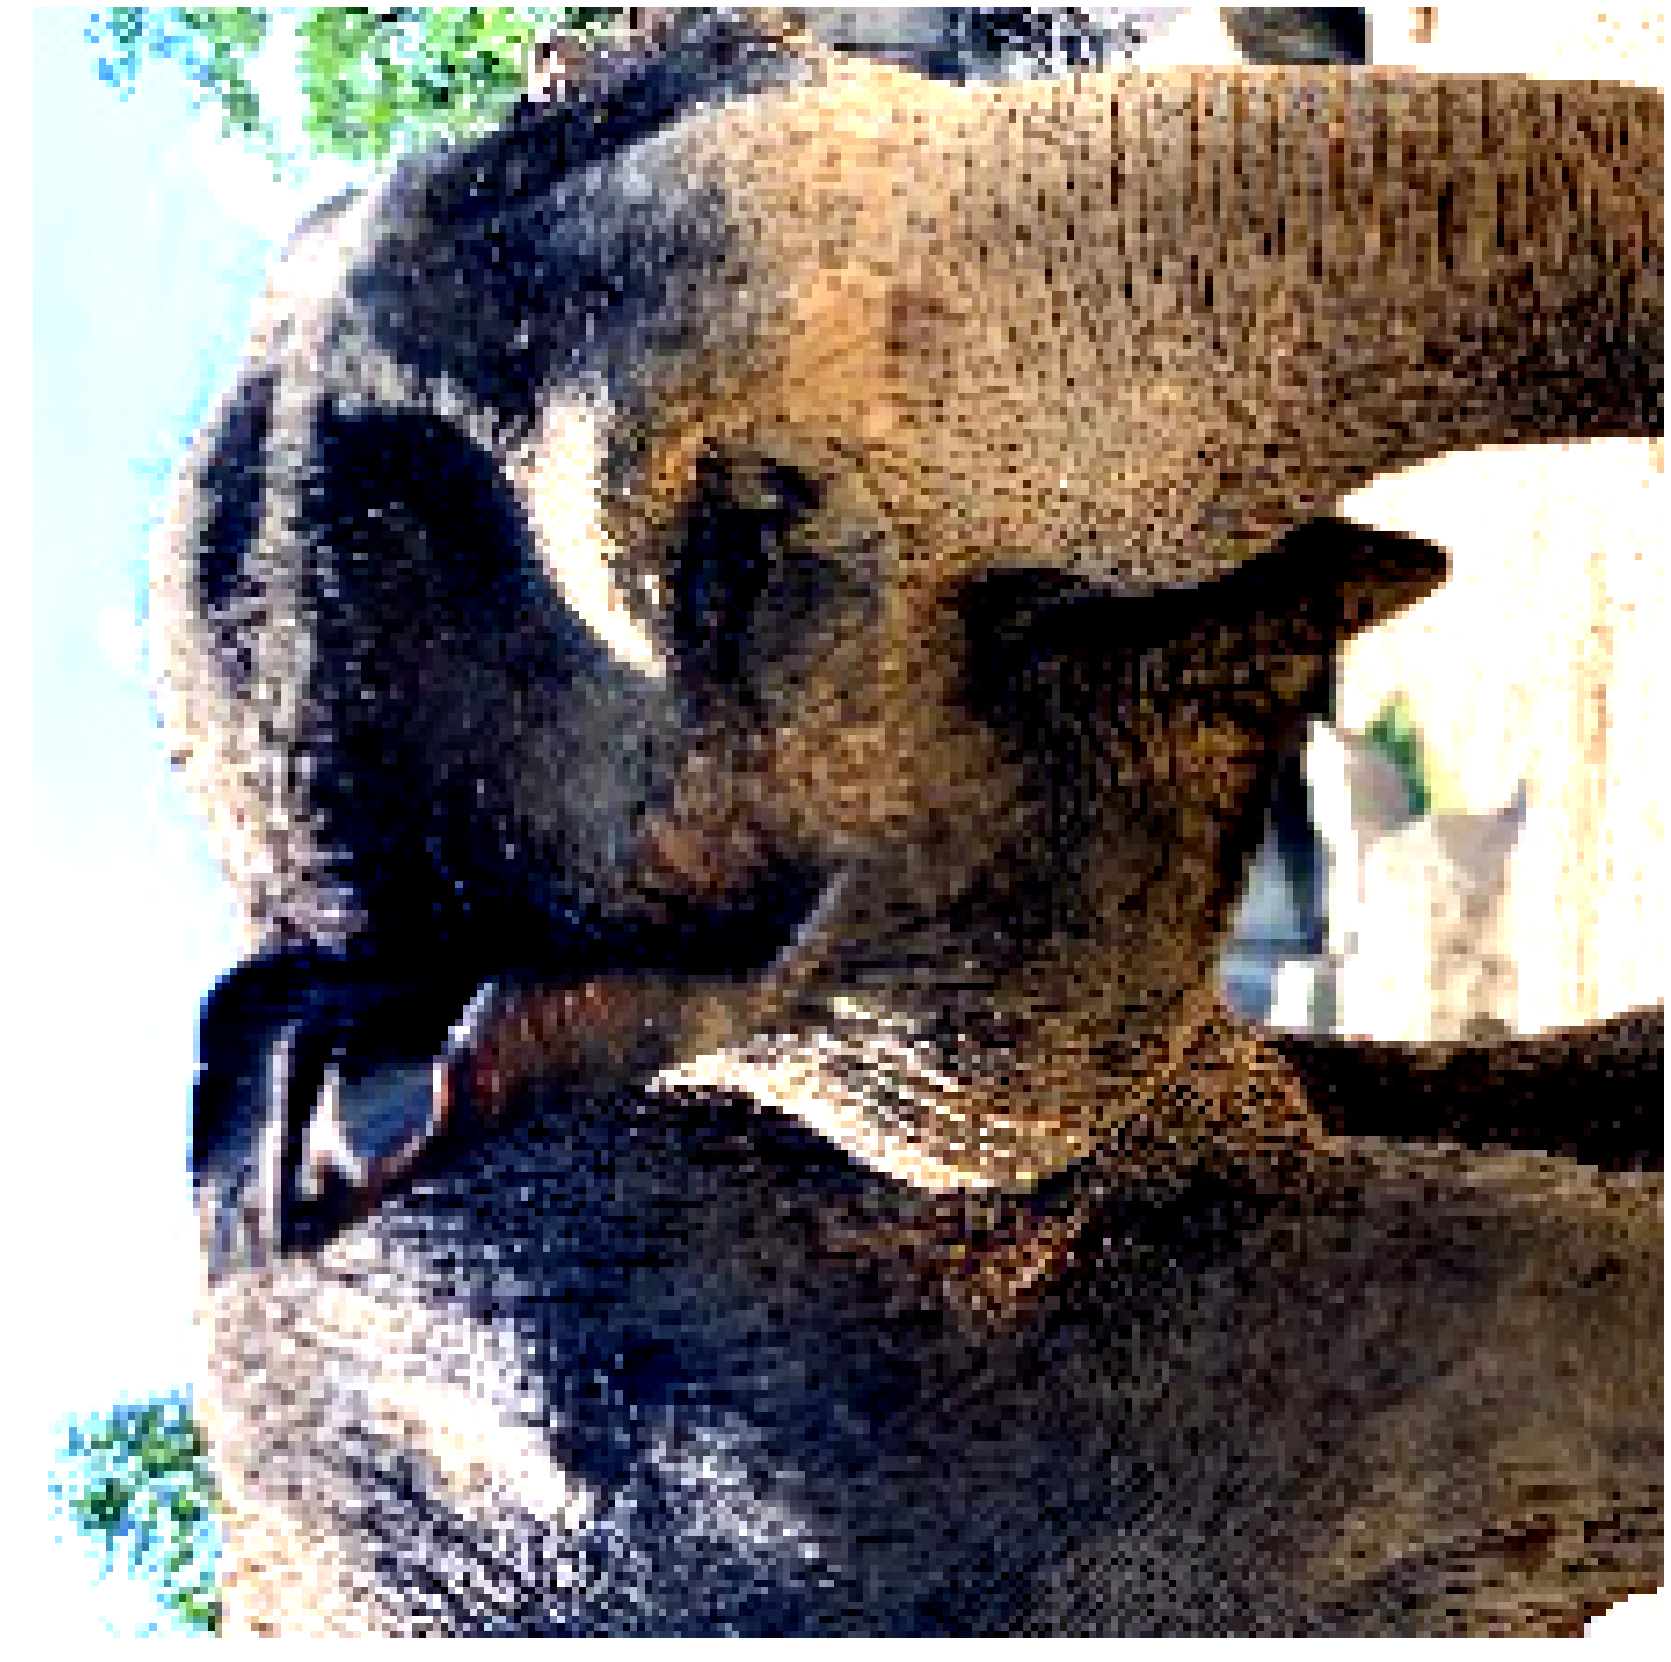

Process Process-2:
Process Process-4:
Process Process-8:
Process Process-7:
Process Process-1:
Process Process-6:
Process Process-3:
Process Process-5:
Traceback (most recent call last):
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run(

  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
KeyboardInterrupt
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 9

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.grid("off")
    plt.show()


# get some random training images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

plt.figure(figsize=(60,30))
# show images
imshow(torchvision.utils.make_grid(images))


 ## Initialize the model

In [9]:
model_name = "resnet"
model = models.resnet50(pretrained = True) if model_name=="resnet" else models.densenet121(pretrained = True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# enable cudalabels
if (torch.cuda.is_available()):
    is_cuda = True
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
else:
    is_cuda = False

print("Initialized the model")

Let's use 8 GPUs!
Initialized the model


In [10]:
if is_cuda:
    criterion  = torch.nn.CrossEntropyLoss().cuda() ## cross entropy loss
else:
    criterion  = torch.nn.CrossEntropyLoss()


In [11]:
elephant_labels = ['Indian_elephant','African_elephant']
CLASS_INDEX = None
idx2label = None
cls2label = None

def decode_predictions(preds):
    global CLASS_INDEX
    global idx2label,cls2label 
    ## If indx is none
    if CLASS_INDEX is None:
        
        fpath = "../data/imagenet_class_index.json"
        idx2label = []
        cls2label = {}
        with open('../data/imagenet_class_index.json','r') as json_file:
            CLASS_INDEX = json.load(json_file)
            idx2label = [CLASS_INDEX[str(k)][1] for k in range(len(CLASS_INDEX))]
            cls2label = {CLASS_INDEX[str(k)][0]: CLASS_INDEX[str(k)][1] for k in range(len(CLASS_INDEX))}

    _, pred = torch.max(preds, 1)   
    results = []
    
    for i in pred:
        label = idx2label[(i)]
        if label in elephant_labels:
            return (1,label)
    return (0,label)
    
    

In [14]:
## set the model to evaluation mode
model.eval()
with torch.no_grad():
    correct = 0
    index_correct = []
    index_incorrect = []
    
    total_images = 0
    for idx, (images, target) in enumerate(test_dataloader):
        if is_cuda:
            images = images.cuda()
            target = target.cuda()

        # compute output
        total_images+=images.size(0)
        outputs = model(images)
        
        ## test loss
        loss = criterion(outputs, target)

        # measure accuracy and record loss
        pred, predicted_label = decode_predictions(outputs.data.cpu())
        correct += pred
        
        if pred==0:
            index_incorrect.append((idx,predicted_label))
        else:
            index_correct.append((idx,predicted_label))
        
        print(f" Accuracy score: {(correct/total_images)*100}")

 Accuracy score: 100.0
 Accuracy score: 50.0
 Accuracy score: 66.66666666666666
 Accuracy score: 75.0
 Accuracy score: 60.0
 Accuracy score: 50.0
 Accuracy score: 57.14285714285714
 Accuracy score: 62.5
 Accuracy score: 66.66666666666666
 Accuracy score: 60.0
 Accuracy score: 63.63636363636363
 Accuracy score: 66.66666666666666
 Accuracy score: 61.53846153846154
 Accuracy score: 57.14285714285714
 Accuracy score: 60.0
 Accuracy score: 62.5
 Accuracy score: 58.82352941176471
 Accuracy score: 61.111111111111114
 Accuracy score: 57.89473684210527
 Accuracy score: 60.0
 Accuracy score: 61.904761904761905
 Accuracy score: 59.09090909090909
 Accuracy score: 60.86956521739131
 Accuracy score: 58.333333333333336
 Accuracy score: 60.0
 Accuracy score: 61.53846153846154
 Accuracy score: 62.96296296296296
 Accuracy score: 64.28571428571429
 Accuracy score: 65.51724137931035
 Accuracy score: 66.66666666666666
 Accuracy score: 67.74193548387096
 Accuracy score: 68.75
 Accuracy score: 69.69696969696

 Accuracy score: 77.32793522267207
 Accuracy score: 77.41935483870968
 Accuracy score: 77.10843373493977
 Accuracy score: 77.2
 Accuracy score: 76.89243027888446
 Accuracy score: 76.98412698412699
 Accuracy score: 76.6798418972332
 Accuracy score: 76.77165354330708
 Accuracy score: 76.86274509803923
 Accuracy score: 76.5625
 Accuracy score: 76.65369649805449
 Accuracy score: 76.74418604651163
 Accuracy score: 76.44787644787645
 Accuracy score: 76.53846153846153
 Accuracy score: 76.62835249042146
 Accuracy score: 76.7175572519084
 Accuracy score: 76.80608365019012
 Accuracy score: 76.89393939393939
 Accuracy score: 76.9811320754717
 Accuracy score: 77.06766917293233
 Accuracy score: 76.77902621722846
 Accuracy score: 76.86567164179104
 Accuracy score: 76.95167286245353
 Accuracy score: 77.03703703703704
 Accuracy score: 77.12177121771218
 Accuracy score: 77.20588235294117
 Accuracy score: 77.2893772893773
 Accuracy score: 77.37226277372264
 Accuracy score: 77.45454545454545
 Accuracy sc

 Accuracy score: 78.35051546391753
 Accuracy score: 78.18930041152264
 Accuracy score: 78.2340862422998
 Accuracy score: 78.27868852459017
 Accuracy score: 78.11860940695297
 Accuracy score: 77.9591836734694
 Accuracy score: 78.00407331975559
 Accuracy score: 78.04878048780488
 Accuracy score: 78.09330628803245
 Accuracy score: 78.13765182186235
 Accuracy score: 77.97979797979798
 Accuracy score: 78.0241935483871
 Accuracy score: 78.06841046277665
 Accuracy score: 78.1124497991968
 Accuracy score: 78.15631262525051
 Accuracy score: 78.2
 Accuracy score: 78.0439121756487
 Accuracy score: 78.08764940239044
 Accuracy score: 78.13121272365805
 Accuracy score: 78.17460317460318
 Accuracy score: 78.01980198019803
 Accuracy score: 78.06324110671937
 Accuracy score: 77.90927021696253
 Accuracy score: 77.95275590551181
 Accuracy score: 77.99607072691552
 Accuracy score: 77.84313725490196
 Accuracy score: 77.88649706457925
 Accuracy score: 77.734375
 Accuracy score: 77.77777777777779
 Accuracy s

 Accuracy score: 75.90027700831024
 Accuracy score: 75.93360995850622
 Accuracy score: 75.96685082872928
 Accuracy score: 76.0
 Accuracy score: 75.89531680440771
 Accuracy score: 75.92847317744153
 Accuracy score: 75.96153846153845
 Accuracy score: 75.85733882030178
 Accuracy score: 75.75342465753425
 Accuracy score: 75.78659370725033
 Accuracy score: 75.81967213114754
 Accuracy score: 75.7162346521146
 Accuracy score: 75.74931880108991
 Accuracy score: 75.78231292517007
 Accuracy score: 75.81521739130434
 Accuracy score: 75.84803256445048
 Accuracy score: 75.88075880758808
 Accuracy score: 75.91339648173206
 Accuracy score: 75.94594594594595
 Accuracy score: 75.97840755735493
 Accuracy score: 76.01078167115904
 Accuracy score: 76.04306864064603
 Accuracy score: 76.0752688172043
 Accuracy score: 76.10738255033557
 Accuracy score: 76.13941018766755
 Accuracy score: 76.17135207496653
 Accuracy score: 76.20320855614973
 Accuracy score: 76.23497997329774
 Accuracy score: 76.26666666666667


 Accuracy score: 77.08333333333334
 Accuracy score: 77.10718002081165
 Accuracy score: 77.02702702702703
 Accuracy score: 76.94704049844236
 Accuracy score: 76.86721991701245
 Accuracy score: 76.89119170984456
 Accuracy score: 76.91511387163561
 Accuracy score: 76.93898655635988
 Accuracy score: 76.96280991735537
 Accuracy score: 76.98658410732713
 Accuracy score: 77.01030927835052
 Accuracy score: 77.03398558187435
 Accuracy score: 77.05761316872429
 Accuracy score: 77.08119218910586
 Accuracy score: 77.1047227926078
 Accuracy score: 77.12820512820512
 Accuracy score: 77.04918032786885
 Accuracy score: 76.97031729785057
 Accuracy score: 76.89161554192229
 Accuracy score: 76.81307456588355
 Accuracy score: 76.83673469387755
 Accuracy score: 76.86034658511723
 Accuracy score: 76.88391038696538
 Accuracy score: 76.90742624618515
 Accuracy score: 76.93089430894308
 Accuracy score: 76.85279187817258
 Accuracy score: 76.77484787018255
 Accuracy score: 76.7983789260385
 Accuracy score: 76.82

 Accuracy score: 77.2765246449457
 Accuracy score: 77.29549248747914
 Accuracy score: 77.31442869057548
 Accuracy score: 77.33333333333333
 Accuracy score: 77.35220649458783
 Accuracy score: 77.28785357737105
 Accuracy score: 77.3067331670823
 Accuracy score: 77.32558139534885
 Accuracy score: 77.26141078838175
 Accuracy score: 77.28026533996683
 Accuracy score: 77.29908864954432
 Accuracy score: 77.31788079470199
 Accuracy score: 77.33664185277088
 Accuracy score: 77.27272727272727
 Accuracy score: 77.29149463253509
 Accuracy score: 77.3102310231023
 Accuracy score: 77.32893652102226
 Accuracy score: 77.34761120263592
 Accuracy score: 77.36625514403292
 Accuracy score: 77.38486842105263
 Accuracy score: 77.40345110928513
 Accuracy score: 77.42200328407225
 Accuracy score: 77.44052502050862
 Accuracy score: 77.37704918032787
 Accuracy score: 77.39557739557739
 Accuracy score: 77.41407528641571
 Accuracy score: 77.35077677841373
 Accuracy score: 77.36928104575163
 Accuracy score: 77.387

 Accuracy score: 76.48290300069783
 Accuracy score: 76.49930264993027
 Accuracy score: 76.44599303135888
 Accuracy score: 76.46239554317549
 Accuracy score: 76.47877522616562
 Accuracy score: 76.49513212795549
 Accuracy score: 76.51146629603892
 Accuracy score: 76.52777777777777
 Accuracy score: 76.54406662040249
 Accuracy score: 76.56033287101248
 Accuracy score: 76.57657657657657
 Accuracy score: 76.59279778393352
 Accuracy score: 76.53979238754324
 Accuracy score: 76.55601659751036
 Accuracy score: 76.50310988251555
 Accuracy score: 76.51933701657458
 Accuracy score: 76.4665286404417
 Accuracy score: 76.48275862068965
 Accuracy score: 76.49896623018608
 Accuracy score: 76.51515151515152
 Accuracy score: 76.46249139710943
 Accuracy score: 76.47867950481431
 Accuracy score: 76.49484536082474
 Accuracy score: 76.51098901098901
 Accuracy score: 76.52711050102951
 Accuracy score: 76.5432098765432
 Accuracy score: 76.55928718300206
 Accuracy score: 76.57534246575342
 Accuracy score: 76.59

 Accuracy score: 76.58682634730539
 Accuracy score: 76.5409934171155
 Accuracy score: 76.55502392344498
 Accuracy score: 76.56903765690377
 Accuracy score: 76.58303464755078
 Accuracy score: 76.53731343283582
 Accuracy score: 76.55131264916469
 Accuracy score: 76.56529516994634
 Accuracy score: 76.5792610250298
 Accuracy score: 76.53365098272782
 Accuracy score: 76.54761904761904
 Accuracy score: 76.56157049375372
 Accuracy score: 76.51605231866824
 Accuracy score: 76.53000594177065
 Accuracy score: 76.54394299287411
 Accuracy score: 76.55786350148368
 Accuracy score: 76.51245551601423
 Accuracy score: 76.52637818612922
 Accuracy score: 76.48104265402843
 Accuracy score: 76.49496743635287
 Accuracy score: 76.50887573964496
 Accuracy score: 76.52276759314014
 Accuracy score: 76.53664302600473
 Accuracy score: 76.55050206733608
 Accuracy score: 76.56434474616293
 Accuracy score: 76.57817109144543
 Accuracy score: 76.59198113207547
 Accuracy score: 76.5468473777254
 Accuracy score: 76.560

 Accuracy score: 76.39979068550498
 Accuracy score: 76.41213389121339
 Accuracy score: 76.42446419236802
 Accuracy score: 76.4367816091954
 Accuracy score: 76.4490861618799
 Accuracy score: 76.46137787056368
 Accuracy score: 76.4736567553469
 Accuracy score: 76.43378519290927
 Accuracy score: 76.4460656591975
 Accuracy score: 76.45833333333333
 Accuracy score: 76.47058823529412
 Accuracy score: 76.4828303850156
 Accuracy score: 76.49505980239209
 Accuracy score: 76.45530145530145
 Accuracy score: 76.41558441558442
 Accuracy score: 76.42782969885774
 Accuracy score: 76.44006227296316
 Accuracy score: 76.40041493775934
 Accuracy score: 76.41264904095387
 Accuracy score: 76.37305699481865
 Accuracy score: 76.38529259451062
 Accuracy score: 76.3975155279503
 Accuracy score: 76.35799275737196
 Accuracy score: 76.31851085832471
 Accuracy score: 76.33074935400516
 Accuracy score: 76.34297520661157
 Accuracy score: 76.30356220960249
 Accuracy score: 76.31578947368422
 Accuracy score: 76.328004

 Accuracy score: 76.33658763365875
 Accuracy score: 76.34758364312268
 Accuracy score: 76.3585694379935
 Accuracy score: 76.36954503249768
 Accuracy score: 76.38051044083527
 Accuracy score: 76.39146567717997
 Accuracy score: 76.40241075567918
 Accuracy score: 76.36700648748842
 Accuracy score: 76.37795275590551
 Accuracy score: 76.38888888888889
 Accuracy score: 76.39981490050903
 Accuracy score: 76.41073080481036
 Accuracy score: 76.37540453074433
 Accuracy score: 76.38632162661737
 Accuracy score: 76.39722863741339
 Accuracy score: 76.40812557710065
 Accuracy score: 76.4190124596216
 Accuracy score: 76.42988929889299
 Accuracy score: 76.39465191332411
 Accuracy score: 76.40552995391705
 Accuracy score: 76.37033625057578
 Accuracy score: 76.38121546961327
 Accuracy score: 76.39208467556374
 Accuracy score: 76.40294388224471
 Accuracy score: 76.41379310344828
 Accuracy score: 76.42463235294117
 Accuracy score: 76.43546164446487
 Accuracy score: 76.44628099173553
 Accuracy score: 76.45

 Accuracy score: 76.51737128505651
 Accuracy score: 76.52719665271967
 Accuracy score: 76.53701380175659
 Accuracy score: 76.50501672240803
 Accuracy score: 76.51483493522775
 Accuracy score: 76.52464494569757
 Accuracy score: 76.53444676409185
 Accuracy score: 76.54424040066779
 Accuracy score: 76.55402586566542
 Accuracy score: 76.52210175145954
 Accuracy score: 76.49020425177157
 Accuracy score: 76.45833333333333
 Accuracy score: 76.42648896293211
 Accuracy score: 76.43630308076604
 Accuracy score: 76.4461090303787
 Accuracy score: 76.41430948419301
 Accuracy score: 76.38253638253639
 Accuracy score: 76.35078969243557
 Accuracy score: 76.31906938097217
 Accuracy score: 76.32890365448505
 Accuracy score: 76.29721876297218
 Accuracy score: 76.3070539419087
 Accuracy score: 76.31688096225633
 Accuracy score: 76.32669983416253
 Accuracy score: 76.33651056775797
 Accuracy score: 76.34631317315659
 Accuracy score: 76.35610766045548
 Accuracy score: 76.3658940397351
 Accuracy score: 76.375

 Accuracy score: 76.53100038037276
 Accuracy score: 76.53992395437263
 Accuracy score: 76.5488407449639
 Accuracy score: 76.55775075987842
 Accuracy score: 76.56665400683632
 Accuracy score: 76.57555049354595
 Accuracy score: 76.584440227704
 Accuracy score: 76.59332321699544
 Accuracy score: 76.56427758816837
 Accuracy score: 76.5352539802881
 Accuracy score: 76.54414550966275
 Accuracy score: 76.51515151515152
 Accuracy score: 76.52404392275653
 Accuracy score: 76.49507948523846
 Accuracy score: 76.50397275822928
 Accuracy score: 76.51285930408473
 Accuracy score: 76.52173913043478
 Accuracy score: 76.53061224489795
 Accuracy score: 76.50170003777862
 Accuracy score: 76.51057401812689
 Accuracy score: 76.51944129860324
 Accuracy score: 76.52830188679245
 Accuracy score: 76.53715579026782
 Accuracy score: 76.54600301659124
 Accuracy score: 76.51715039577837
 Accuracy score: 76.525998492841
 Accuracy score: 76.53483992467042
 Accuracy score: 76.54367469879519
 Accuracy score: 76.552502

 Accuracy score: 76.56086501569584
 Accuracy score: 76.56903765690377
 Accuracy score: 76.57720460090623
 Accuracy score: 76.55052264808361
 Accuracy score: 76.52385928247996
 Accuracy score: 76.53203342618384
 Accuracy score: 76.54020187956839
 Accuracy score: 76.54836464857343
 Accuracy score: 76.55652173913043
 Accuracy score: 76.56467315716272
 Accuracy score: 76.57281890858533
 Accuracy score: 76.546212647672
 Accuracy score: 76.51962486974644
 Accuracy score: 76.49305555555556
 Accuracy score: 76.46650468587296
 Accuracy score: 76.43997224149895
 Accuracy score: 76.4134582032605
 Accuracy score: 76.42163661581137
 Accuracy score: 76.3951473136915
 Accuracy score: 76.4033264033264
 Accuracy score: 76.41149982680983
 Accuracy score: 76.38504155124653
 Accuracy score: 76.35860159224646
 Accuracy score: 76.36678200692042
 Accuracy score: 76.37495676236597
 Accuracy score: 76.38312586445366
 Accuracy score: 76.39128931904597
 Accuracy score: 76.39944713199723
 Accuracy score: 76.40759

 Accuracy score: 76.3776990009668
 Accuracy score: 76.3853092783505
 Accuracy score: 76.36070853462158
 Accuracy score: 76.3683193818416
 Accuracy score: 76.37592532990023
 Accuracy score: 76.38352638352637
 Accuracy score: 76.3911225474429
 Accuracy score: 76.39871382636656
 Accuracy score: 76.40630022500804
 Accuracy score: 76.38174807197944
 Accuracy score: 76.38933504657886
 Accuracy score: 76.39691714836223
 Accuracy score: 76.40449438202246
 Accuracy score: 76.41206675224646
 Accuracy score: 76.38755213346167
 Accuracy score: 76.36305323925593
 Accuracy score: 76.33857005450466
 Accuracy score: 76.34615384615384
 Accuracy score: 76.35373277795578
 Accuracy score: 76.32927610506086
 Accuracy score: 76.33685558757605
 Accuracy score: 76.34443021766965
 Accuracy score: 76.352
 Accuracy score: 76.3275751759437
 Accuracy score: 76.3351455068756
 Accuracy score: 76.34271099744245
 Accuracy score: 76.3183125599233
 Accuracy score: 76.29392971246006
 Accuracy score: 76.30150111785372
 Ac

 Accuracy score: 76.09799820734987
 Accuracy score: 76.10513739545998
 Accuracy score: 76.11227232009556
 Accuracy score: 76.11940298507463
 Accuracy score: 76.12652939421068
 Accuracy score: 76.10381861575179
 Accuracy score: 76.11094542201015
 Accuracy score: 76.1180679785331
 Accuracy score: 76.09538002980626
 Accuracy score: 76.07270560190703
 Accuracy score: 76.07983318439082
 Accuracy score: 76.05717689100655
 Accuracy score: 76.0643048526347
 Accuracy score: 76.07142857142857
 Accuracy score: 76.07854805117525
 Accuracy score: 76.05591909577633
 Accuracy score: 76.06303895331548
 Accuracy score: 76.07015457788347
 Accuracy score: 76.07726597325409
 Accuracy score: 76.08437314319667
 Accuracy score: 76.0914760914761
 Accuracy score: 76.09857482185272
 Accuracy score: 76.10566933808252
 Accuracy score: 76.11275964391692
 Accuracy score: 76.11984574310293
 Accuracy score: 76.12692763938315
 Accuracy score: 76.10435813815594
 Accuracy score: 76.11144042679312
 Accuracy score: 76.118

 Accuracy score: 75.94089768608865
 Accuracy score: 75.94760312151617
 Accuracy score: 75.92644190582335
 Accuracy score: 75.93314763231199
 Accuracy score: 75.9120022277917
 Accuracy score: 75.89086859688196
 Accuracy score: 75.89757862510437
 Accuracy score: 75.90428491930996
 Accuracy score: 75.91098748261474
 Accuracy score: 75.91768631813126
 Accuracy score: 75.92438142896859
 Accuracy score: 75.93107281823235
 Accuracy score: 75.90997499305362
 Accuracy score: 75.91666666666667
 Accuracy score: 75.92335462371564
 Accuracy score: 75.93003886729595
 Accuracy score: 75.93671940049958
 Accuracy score: 75.94339622641509
 Accuracy score: 75.9500693481276
 Accuracy score: 75.95673876871881
 Accuracy score: 75.96340449126699
 Accuracy score: 75.970066518847
 Accuracy score: 75.94901634801884
 Accuracy score: 75.95567867036011
 Accuracy score: 75.9346441428967
 Accuracy score: 75.94130675526024
 Accuracy score: 75.94796567949072
 Accuracy score: 75.92695074709464
 Accuracy score: 75.93360

 Accuracy score: 75.7710402509148
 Accuracy score: 75.77737130911942
 Accuracy score: 75.75757575757575
 Accuracy score: 75.76390702533298
 Accuracy score: 75.77023498694517
 Accuracy score: 75.77655964500131
 Accuracy score: 75.78288100208769
 Accuracy score: 75.76310983563788
 Accuracy score: 75.76943140323422
 Accuracy score: 75.77574967405477
 Accuracy score: 75.7820646506778
 Accuracy score: 75.76231430805316
 Accuracy score: 75.76862949452841
 Accuracy score: 75.77494139098724
 Accuracy score: 75.78125
 Accuracy score: 75.78755532413433
 Accuracy score: 75.76782925559604
 Accuracy score: 75.77413479052824
 Accuracy score: 75.78043704474506
 Accuracy score: 75.78673602080625
 Accuracy score: 75.79303172126886
 Accuracy score: 75.79932414868729
 Accuracy score: 75.8056133056133
 Accuracy score: 75.78591842036893
 Accuracy score: 75.79220779220779
 Accuracy score: 75.77252661646325
 Accuracy score: 75.77881619937695
 Accuracy score: 75.7591487152868
 Accuracy score: 75.7654385054488

 Accuracy score: 75.78740157480314
 Accuracy score: 75.79335793357933
 Accuracy score: 75.79931136251845
 Accuracy score: 75.80526186378165
 Accuracy score: 75.78662733529991
 Accuracy score: 75.76800196608502
 Accuracy score: 75.77395577395578
 Accuracy score: 75.77990665684106
 Accuracy score: 75.78585461689588
 Accuracy score: 75.76724772894671
 Accuracy score: 75.77319587628865
 Accuracy score: 75.77914110429448
 Accuracy score: 75.78508341511285
 Accuracy score: 75.76649497179298
 Accuracy score: 75.77243746934772
 Accuracy score: 75.7783770531993
 Accuracy score: 75.75980392156862
 Accuracy score: 75.76574369027199
 Accuracy score: 75.77168054875061
 Accuracy score: 75.77761449914279
 Accuracy score: 75.78354554358472
 Accuracy score: 75.76499388004896
 Accuracy score: 75.77092511013215
 Accuracy score: 75.77685343772939
 Accuracy score: 75.78277886497065
 Accuracy score: 75.76424553680606
 Accuracy score: 75.77017114914425
 Accuracy score: 75.77609386458079
 Accuracy score: 75.7

 Accuracy score: 75.91817759181777
 Accuracy score: 75.92377411108528
 Accuracy score: 75.92936802973978
 Accuracy score: 75.9349593495935
 Accuracy score: 75.94054807245703
 Accuracy score: 75.9461342001393
 Accuracy score: 75.95171773444754
 Accuracy score: 75.93409143652819
 Accuracy score: 75.93967517401393
 Accuracy score: 75.9452563210392
 Accuracy score: 75.9508348794063
 Accuracy score: 75.93322513331788
 Accuracy score: 75.93880389429764
 Accuracy score: 75.94438006952491
 Accuracy score: 75.92678405931417
 Accuracy score: 75.93236043548761
 Accuracy score: 75.91477535896249
 Accuracy score: 75.89719842556147
 Accuracy score: 75.90277777777777
 Accuracy score: 75.88521175653784
 Accuracy score: 75.86765386395187
 Accuracy score: 75.8501040943789
 Accuracy score: 75.85568917668826
 Accuracy score: 75.86127167630057
 Accuracy score: 75.86685159500693
 Accuracy score: 75.8493182343425
 Accuracy score: 75.85489833641404
 Accuracy score: 75.83737583737584
 Accuracy score: 75.842956

 Accuracy score: 75.6494936151475
 Accuracy score: 75.65485362095532
 Accuracy score: 75.66021126760563
 Accuracy score: 75.66556655665566
 Accuracy score: 75.67091948966123
 Accuracy score: 75.67627006817682
 Accuracy score: 75.68161829375549
 Accuracy score: 75.686964167949
 Accuracy score: 75.67032967032968
 Accuracy score: 75.67567567567568
 Accuracy score: 75.6810193321617
 Accuracy score: 75.68636064133538
 Accuracy score: 75.69169960474308
 Accuracy score: 75.69703622392974
 Accuracy score: 75.70237050043899
 Accuracy score: 75.70770243581305
 Accuracy score: 75.7130320315928
 Accuracy score: 75.71835928931783
 Accuracy score: 75.72368421052632
 Accuracy score: 75.7290067967551
 Accuracy score: 75.73432704953967
 Accuracy score: 75.7396449704142
 Accuracy score: 75.74496056091148
 Accuracy score: 75.75027382256297
 Accuracy score: 75.75558475689881
 Accuracy score: 75.73899715349245
 Accuracy score: 75.74430823117339
 Accuracy score: 75.74961698402277
 Accuracy score: 75.7549234

 Accuracy score: 75.60159029085582
 Accuracy score: 75.60669456066945
 Accuracy score: 75.61179669525204
 Accuracy score: 75.61689669594313
 Accuracy score: 75.60108718377587
 Accuracy score: 75.6061872909699
 Accuracy score: 75.61128526645768
 Accuracy score: 75.61638111157542
 Accuracy score: 75.62147482765825
 Accuracy score: 75.62656641604009
 Accuracy score: 75.63165587805388
 Accuracy score: 75.61586638830897
 Accuracy score: 75.62095595908997
 Accuracy score: 75.62604340567613
 Accuracy score: 75.63112872939703
 Accuracy score: 75.63621193158114
 Accuracy score: 75.64129301355578
 Accuracy score: 75.6255212677231
 Accuracy score: 75.63060245987076
 Accuracy score: 75.63568153397249
 Accuracy score: 75.64075849135237
 Accuracy score: 75.64583333333333
 Accuracy score: 75.65090606123725
 Accuracy score: 75.65597667638484
 Accuracy score: 75.66104518009578
 Accuracy score: 75.66611157368858
 Accuracy score: 75.67117585848074
 Accuracy score: 75.65543071161048
 Accuracy score: 75.66

 Accuracy score: 75.72738142686329
 Accuracy score: 75.73221757322176
 Accuracy score: 75.73705179282868
 Accuracy score: 75.74188408683528
 Accuracy score: 75.74671445639187
 Accuracy score: 75.75154290264781
 Accuracy score: 75.75636942675159
 Accuracy score: 75.7412935323383
 Accuracy score: 75.74612017508954
 Accuracy score: 75.75094489755321
 Accuracy score: 75.7557677008751
 Accuracy score: 75.76058858620004
 Accuracy score: 75.76540755467197
 Accuracy score: 75.7503478433711
 Accuracy score: 75.75516693163752
 Accuracy score: 75.7599841049076
 Accuracy score: 75.76479936432261
 Accuracy score: 75.76961271102284
 Accuracy score: 75.75456711675933
 Accuracy score: 75.75938058368075
 Accuracy score: 75.764192139738
 Accuracy score: 75.76900178606867
 Accuracy score: 75.77380952380952
 Accuracy score: 75.77861535409642
 Accuracy score: 75.7635858786196
 Accuracy score: 75.74856236367242
 Accuracy score: 75.7533703409992
 Accuracy score: 75.75817641228939
 Accuracy score: 75.74316290

 Accuracy score: 76.04642313546424
 Accuracy score: 76.05097964618604
 Accuracy score: 76.05553442373527
 Accuracy score: 76.0600874691006
 Accuracy score: 76.06463878326997
 Accuracy score: 76.06918836723057
 Accuracy score: 76.05473204104904
 Accuracy score: 76.05928177845335
 Accuracy score: 76.06382978723404
 Accuracy score: 76.06837606837607
 Accuracy score: 76.07292062286365
 Accuracy score: 76.07746345168027
 Accuracy score: 76.08200455580865
 Accuracy score: 76.08654393623078
 Accuracy score: 76.0910815939279
 Accuracy score: 76.09561752988047
 Accuracy score: 76.10015174506829
 Accuracy score: 76.10468424047032
 Accuracy score: 76.10921501706484
 Accuracy score: 76.11374407582939
 Accuracy score: 76.11827141774071
 Accuracy score: 76.1038468826985
 Accuracy score: 76.10837438423646
 Accuracy score: 76.11290017048682
 Accuracy score: 76.11742424242425
 Accuracy score: 76.12194660102254
 Accuracy score: 76.12646724725482
 Accuracy score: 76.13098618209351
 Accuracy score: 76.116

 Accuracy score: 76.11070648215586
 Accuracy score: 76.1150555252139
 Accuracy score: 76.11940298507463
 Accuracy score: 76.10555050045495
 Accuracy score: 76.1098981077147
 Accuracy score: 76.11424413316354
 Accuracy score: 76.11858857766461
 Accuracy score: 76.12293144208037
 Accuracy score: 76.10909090909091
 Accuracy score: 76.11343392110525
 Accuracy score: 76.11777535441658
 Accuracy score: 76.12211520988552
 Accuracy score: 76.12645348837209
 Accuracy score: 76.1307901907357
 Accuracy score: 76.13512531783509
 Accuracy score: 76.12130016342836
 Accuracy score: 76.12563543936093
 Accuracy score: 76.12996914140497
 Accuracy score: 76.13430127041742
 Accuracy score: 76.13863182725457
 Accuracy score: 76.14296081277213
 Accuracy score: 76.14728822782514
 Accuracy score: 76.13347841857092
 Accuracy score: 76.13780598368088
 Accuracy score: 76.12400290065264
 Accuracy score: 76.12833061446437
 Accuracy score: 76.13265675969554
 Accuracy score: 76.11886211270158
 Accuracy score: 76.105

 Accuracy score: 76.08240223463687
 Accuracy score: 76.08657706406005
 Accuracy score: 76.09075043630017
 Accuracy score: 76.09492235212005
 Accuracy score: 76.09909281228192
 Accuracy score: 76.08581894296181
 Accuracy score: 76.08998953610046
 Accuracy score: 76.07672188317349
 Accuracy score: 76.08089260808926
 Accuracy score: 76.08506187903086
 Accuracy score: 76.08922969675845
 Accuracy score: 76.09339606203172
 Accuracy score: 76.0801393728223
 Accuracy score: 76.06688730186379
 Accuracy score: 76.0536398467433
 Accuracy score: 76.0578095072262
 Accuracy score: 76.04456824512535
 Accuracy score: 76.04873803307224
 Accuracy score: 76.05290636964845
 Accuracy score: 76.05707325561161
 Accuracy score: 76.06123869171886
 Accuracy score: 76.06540267872674
 Accuracy score: 76.0695652173913
 Accuracy score: 76.05633802816901
 Accuracy score: 76.0605006954103
 Accuracy score: 76.06466191552234
 Accuracy score: 76.06882168925965
 Accuracy score: 76.0729800173762
 Accuracy score: 76.077136

 Accuracy score: 76.20724346076459
 Accuracy score: 76.21123218776195
 Accuracy score: 76.19845792826014
 Accuracy score: 76.20244679068209
 Accuracy score: 76.20643431635389
 Accuracy score: 76.19366728095159
 Accuracy score: 76.18090452261306
 Accuracy score: 76.16814603918941
 Accuracy score: 76.17213663764232
 Accuracy score: 76.1761258998828
 Accuracy score: 76.16337462336793
 Accuracy score: 76.1673640167364
 Accuracy score: 76.17135207496653
 Accuracy score: 76.15860799732307
 Accuracy score: 76.16259618601539
 Accuracy score: 76.16658304064224
 Accuracy score: 76.15384615384615
 Accuracy score: 76.15783313827119
 Accuracy score: 76.16181878970244
 Accuracy score: 76.16580310880829
 Accuracy score: 76.16978609625669
 Accuracy score: 76.17376775271512
 Accuracy score: 76.17774807885066
 Accuracy score: 76.16502421914147
 Accuracy score: 76.15230460921843
 Accuracy score: 76.15628652529638
 Accuracy score: 76.16026711185309
 Accuracy score: 76.16424636955433
 Accuracy score: 76.16

 Accuracy score: 76.28566822505239
 Accuracy score: 76.28949065119278
 Accuracy score: 76.29331184528606
 Accuracy score: 76.29713180792781
 Accuracy score: 76.28483969711615
 Accuracy score: 76.28865979381443
 Accuracy score: 76.29247866000966
 Accuracy score: 76.29629629629629
 Accuracy score: 76.3001127032684
 Accuracy score: 76.30392788151964
 Accuracy score: 76.29164654756157
 Accuracy score: 76.29546186031541
 Accuracy score: 76.29927594529364
 Accuracy score: 76.28700128700129
 Accuracy score: 76.290815505871
 Accuracy score: 76.2946284979093
 Accuracy score: 76.29844026370799
 Accuracy score: 76.28617363344051
 Accuracy score: 76.27391094679312
 Accuracy score: 76.27772420443587
 Accuracy score: 76.26546681664792
 Accuracy score: 76.26928020565553
 Accuracy score: 76.2570281124498
 Accuracy score: 76.26084163186637
 Accuracy score: 76.24859482897062
 Accuracy score: 76.25240847784201
 Accuracy score: 76.25622090223149
 Accuracy score: 76.26003210272873
 Accuracy score: 76.26384

 Accuracy score: 76.32355224344046
 Accuracy score: 76.32722756907793
 Accuracy score: 76.33090175384137
 Accuracy score: 76.33457479826194
 Accuracy score: 76.33824670287044
 Accuracy score: 76.34191746819732
 Accuracy score: 76.34558709477275
 Accuracy score: 76.34925558312655
 Accuracy score: 76.35292293378818
 Accuracy score: 76.35658914728683
 Accuracy score: 76.36025422415129
 Accuracy score: 76.3639181649101
 Accuracy score: 76.36758097009142
 Accuracy score: 76.37124264022312
 Accuracy score: 76.37490317583269
 Accuracy score: 76.363073110285
 Accuracy score: 76.36673377729596
 Accuracy score: 76.35490864044596
 Accuracy score: 76.3585694379935
 Accuracy score: 76.36222910216718
 Accuracy score: 76.36588763349327
 Accuracy score: 76.36954503249768
 Accuracy score: 76.37320129970601
 Accuracy score: 76.37685643564357
 Accuracy score: 76.36504253673627
 Accuracy score: 76.35323229198886
 Accuracy score: 76.3568888201639
 Accuracy score: 76.34508348794064
 Accuracy score: 76.34874

 Accuracy score: 76.35519616651692
 Accuracy score: 76.34376403653242
 Accuracy score: 76.34730538922156
 Accuracy score: 76.35084568178416
 Accuracy score: 76.3543849146962
 Accuracy score: 76.35792308843334
 Accuracy score: 76.36146020347098
 Accuracy score: 76.36499626028423
 Accuracy score: 76.36853125934789
 Accuracy score: 76.37206520113654
 Accuracy score: 76.3755980861244
 Accuracy score: 76.37912991478547
 Accuracy score: 76.38266068759341
 Accuracy score: 76.38619040502167
 Accuracy score: 76.38971906754334
 Accuracy score: 76.37830569251457
 Accuracy score: 76.38183447863759
 Accuracy score: 76.38536221060494
 Accuracy score: 76.38888888888889
 Accuracy score: 76.39241451396147
 Accuracy score: 76.39593908629442
 Accuracy score: 76.39946260635917
 Accuracy score: 76.40298507462686
 Accuracy score: 76.40650649156842
 Accuracy score: 76.41002685765443
 Accuracy score: 76.39862748023273
 Accuracy score: 76.40214797136038
 Accuracy score: 76.40566741237882
 Accuracy score: 76.40

 Accuracy score: 76.35496459025872
 Accuracy score: 76.35838150289017
 Accuracy score: 76.36179742811733
 Accuracy score: 76.35076567466051
 Accuracy score: 76.35418171313015
 Accuracy score: 76.3575967648758
 Accuracy score: 76.3610108303249
 Accuracy score: 76.36442390990472
 Accuracy score: 76.35339974014725
 Accuracy score: 76.34237875288684
 Accuracy score: 76.34579304372924
 Accuracy score: 76.34920634920634
 Accuracy score: 76.35261866974461
 Accuracy score: 76.35603000577034
 Accuracy score: 76.3594403577095
 Accuracy score: 76.36284972598789
 Accuracy score: 76.366258111031
 Accuracy score: 76.36966551326412
 Accuracy score: 76.37307193311229
 Accuracy score: 76.37647737100028
 Accuracy score: 76.36547052889465
 Accuracy score: 76.35446685878962
 Accuracy score: 76.34346635931422
 Accuracy score: 76.34687409968309
 Accuracy score: 76.35028085841856
 Accuracy score: 76.3536866359447
 Accuracy score: 76.3570914326854
 Accuracy score: 76.34609847394184
 Accuracy score: 76.3351086

 Accuracy score: 76.46730016769145
 Accuracy score: 76.47058823529412
 Accuracy score: 76.47387538418553
 Accuracy score: 76.47716161475067
 Accuracy score: 76.4804469273743
 Accuracy score: 76.483731322441
 Accuracy score: 76.47305222005026
 Accuracy score: 76.47633673042021
 Accuracy score: 76.47962032384143
 Accuracy score: 76.48290300069783
 Accuracy score: 76.48618476137315
 Accuracy score: 76.48946560625087
 Accuracy score: 76.49274553571429
 Accuracy score: 76.49602455014647
 Accuracy score: 76.49930264993027
 Accuracy score: 76.50257983544833
 Accuracy score: 76.49191299498048
 Accuracy score: 76.49519029694687
 Accuracy score: 76.4984666852523
 Accuracy score: 76.50174216027874
 Accuracy score: 76.50501672240803
 Accuracy score: 76.50829037202173
 Accuracy score: 76.49763165227083
 Accuracy score: 76.50090541858198
 Accuracy score: 76.50417827298051
 Accuracy score: 76.50745021584737
 Accuracy score: 76.51072124756335
 Accuracy score: 76.50006960879855
 Accuracy score: 76.4894

 Accuracy score: 76.521503922099
 Accuracy score: 76.52467883705206
 Accuracy score: 76.52785289345591
 Accuracy score: 76.51750709747195
 Accuracy score: 76.52068126520682
 Accuracy score: 76.52385457494256
 Accuracy score: 76.51351351351352
 Accuracy score: 76.51668693419809
 Accuracy score: 76.51985949743313
 Accuracy score: 76.50952316628394
 Accuracy score: 76.49918962722853
 Accuracy score: 76.50236326806213
 Accuracy score: 76.50553605184986
 Accuracy score: 76.50870797893884
 Accuracy score: 76.51187904967603
 Accuracy score: 76.51504926440815
 Accuracy score: 76.51821862348179
 Accuracy score: 76.52138712724329
 Accuracy score: 76.52455477603885
 Accuracy score: 76.5277215702145
 Accuracy score: 76.530887510116
 Accuracy score: 76.53405259608901
 Accuracy score: 76.53721682847896
 Accuracy score: 76.54038020763112
 Accuracy score: 76.54354273389053
 Accuracy score: 76.53322550208924
 Accuracy score: 76.53638814016173
 Accuracy score: 76.53954992588599
 Accuracy score: 76.52923

 Accuracy score: 76.62082514734774
 Accuracy score: 76.61079099004715
 Accuracy score: 76.61385360743748
 Accuracy score: 76.61691542288557
 Accuracy score: 76.60688571802592
 Accuracy score: 76.59685863874346
 Accuracy score: 76.59992147624656
 Accuracy score: 76.58989793247841
 Accuracy score: 76.5929608792359
 Accuracy score: 76.59602302459444
 Accuracy score: 76.59908436886855
 Accuracy score: 76.58906617839392
 Accuracy score: 76.59212763175101
 Accuracy score: 76.59518828451883
 Accuracy score: 76.59824813701137
 Accuracy score: 76.6013071895425
 Accuracy score: 76.59129525552216
 Accuracy score: 76.59435441714585
 Accuracy score: 76.59741277930223
 Accuracy score: 76.60047034230467
 Accuracy score: 76.60352710646636
 Accuracy score: 76.59352142110762
 Accuracy score: 76.59657829437117
 Accuracy score: 76.59963436928702
 Accuracy score: 76.58963311137225
 Accuracy score: 76.59268929503916
 Accuracy score: 76.59574468085107
 Accuracy score: 76.59879926912033
 Accuracy score: 76.60

 Accuracy score: 76.6895325203252
 Accuracy score: 76.69249333163978
 Accuracy score: 76.69545339090679
 Accuracy score: 76.6984126984127
 Accuracy score: 76.70137125444388
 Accuracy score: 76.70432905928654
 Accuracy score: 76.7072861132267
 Accuracy score: 76.71024241655033
 Accuracy score: 76.7005076142132
 Accuracy score: 76.70346402740769
 Accuracy score: 76.7064196904339
 Accuracy score: 76.70937460357732
 Accuracy score: 76.71232876712328
 Accuracy score: 76.715282181357
 Accuracy score: 76.71823484656353
 Accuracy score: 76.70850767085076
 Accuracy score: 76.71146044624746
 Accuracy score: 76.71441247306376
 Accuracy score: 76.71736375158429
 Accuracy score: 76.70764161703207
 Accuracy score: 76.71059300557526
 Accuracy score: 76.71354364626885
 Accuracy score: 76.716493539397
 Accuracy score: 76.71944268524382
 Accuracy score: 76.72239108409322
 Accuracy score: 76.72533873622895
 Accuracy score: 76.72828564193466
 Accuracy score: 76.71857197113559
 Accuracy score: 76.721518987

 Accuracy score: 76.75622381069755
 Accuracy score: 76.75908810844115
 Accuracy score: 76.761951700345
 Accuracy score: 76.76481458666996
 Accuracy score: 76.76767676767676
 Accuracy score: 76.77053824362606
 Accuracy score: 76.76108374384236
 Accuracy score: 76.76394532693018
 Accuracy score: 76.76680620536813
 Accuracy score: 76.76966637941646
 Accuracy score: 76.77252584933531
 Accuracy score: 76.77538461538461
 Accuracy score: 76.77824267782427
 Accuracy score: 76.78110003691398
 Accuracy score: 76.77165354330708
 Accuracy score: 76.77451100996433
 Accuracy score: 76.76506765067651
 Accuracy score: 76.76792522444964
 Accuracy score: 76.77078209542549
 Accuracy score: 76.77363826386328
 Accuracy score: 76.76419965576592
 Accuracy score: 76.75476336816226
 Accuracy score: 76.75762045231072
 Accuracy score: 76.76047683421409
 Accuracy score: 76.76333251413124
 Accuracy score: 76.76618749232092
 Accuracy score: 76.76904176904176
 Accuracy score: 76.77189534455226
 Accuracy score: 76.77

 Accuracy score: 76.80239520958084
 Accuracy score: 76.80517303316968
 Accuracy score: 76.79597701149426
 Accuracy score: 76.79875493834551
 Accuracy score: 76.80153220014364
 Accuracy score: 76.79233991621783
 Accuracy score: 76.7951172809957
 Accuracy score: 76.7859279645806
 Accuracy score: 76.78870543192151
 Accuracy score: 76.79148223471707
 Accuracy score: 76.78229665071771
 Accuracy score: 76.78507355579475
 Accuracy score: 76.77589093518297
 Accuracy score: 76.77866794212603
 Accuracy score: 76.78144428503109
 Accuracy score: 76.78421996413628
 Accuracy score: 76.78699497967966
 Accuracy score: 76.78976933189912
 Accuracy score: 76.78059273422562
 Accuracy score: 76.77141832954952
 Accuracy score: 76.77419354838709
 Accuracy score: 76.77696810416916
 Accuracy score: 76.7797419971333
 Accuracy score: 76.78251522751702
 Accuracy score: 76.78528779555768
 Accuracy score: 76.78805970149254
 Accuracy score: 76.79083094555874
 Accuracy score: 76.78166408021964
 Accuracy score: 76.772

 Accuracy score: 76.81918733263477
 Accuracy score: 76.82188591385332
 Accuracy score: 76.82458386683739
 Accuracy score: 76.81564245810057
 Accuracy score: 76.8183405097172
 Accuracy score: 76.82103793344194
 Accuracy score: 76.82373472949389
 Accuracy score: 76.82643089809214
 Accuracy score: 76.8174944748168
 Accuracy score: 76.80856013026285
 Accuracy score: 76.81125712292128
 Accuracy score: 76.81395348837209
 Accuracy score: 76.81664922683409
 Accuracy score: 76.80771913508487
 Accuracy score: 76.81041497152155
 Accuracy score: 76.80148768014877
 Accuracy score: 76.8041836141778
 Accuracy score: 76.79525912154311
 Accuracy score: 76.79795515278262
 Accuracy score: 76.80065055762083
 Accuracy score: 76.80334533627598
 Accuracy score: 76.80603948896632
 Accuracy score: 76.80873301590988
 Accuracy score: 76.81142591732466
 Accuracy score: 76.8025078369906
 Accuracy score: 76.79359182725796
 Accuracy score: 76.79628554846198
 Accuracy score: 76.78737233054783
 Accuracy score: 76.7900

 Accuracy score: 76.8202921526441
 Accuracy score: 76.82291666666666
 Accuracy score: 76.82554058643723
 Accuracy score: 76.82816391215758
 Accuracy score: 76.81946802490096
 Accuracy score: 76.82209144409235
 Accuracy score: 76.8247142695485
 Accuracy score: 76.82733650147092
 Accuracy score: 76.8299581400611
 Accuracy score: 76.8212669683258
 Accuracy score: 76.82388870037326
 Accuracy score: 76.81520018095453
 Accuracy score: 76.81782200610652
 Accuracy score: 76.80913613749435
 Accuracy score: 76.81175805539853
 Accuracy score: 76.81437938051097
 Accuracy score: 76.8056968463886
 Accuracy score: 76.80831826401446
 Accuracy score: 76.81093908916262
 Accuracy score: 76.80225988700565
 Accuracy score: 76.80488080442888
 Accuracy score: 76.8075011296882
 Accuracy score: 76.8101208629843
 Accuracy score: 76.81274000451774
 Accuracy score: 76.815358554489
 Accuracy score: 76.81797651309846
 Accuracy score: 76.8093033758609
 Accuracy score: 76.81192142695869
 Accuracy score: 76.8145388870

 Accuracy score: 76.76444640494044
 Accuracy score: 76.75598191641856
 Accuracy score: 76.7585446527012
 Accuracy score: 76.76110682394443
 Accuracy score: 76.7636684303351
 Accuracy score: 76.7552077592858
 Accuracy score: 76.75776945117919
 Accuracy score: 76.74931129476585
 Accuracy score: 76.74085500220362
 Accuracy score: 76.74341742866586
 Accuracy score: 76.74597929059263
 Accuracy score: 76.7485405881705
 Accuracy score: 76.7511013215859
 Accuracy score: 76.75366149102521
 Accuracy score: 76.75622109667474
 Accuracy score: 76.75878013872068
 Accuracy score: 76.76133861734918
 Accuracy score: 76.75288937809577
 Accuracy score: 76.74444199867929
 Accuracy score: 76.73599647848575
 Accuracy score: 76.73855633802818
 Accuracy score: 76.74111563428319
 Accuracy score: 76.74367436743674
 Accuracy score: 76.73523264767353
 Accuracy score: 76.7377914650242
 Accuracy score: 76.72935224898274
 Accuracy score: 76.73191115020893
 Accuracy score: 76.73446948873007
 Accuracy score: 76.737027

 Accuracy score: 76.70320223511713
 Accuracy score: 76.70570538304501
 Accuracy score: 76.69746454662656
 Accuracy score: 76.68922548071758
 Accuracy score: 76.69172932330827
 Accuracy score: 76.6834926431103
 Accuracy score: 76.6859965635739
 Accuracy score: 76.68849994631161
 Accuracy score: 76.69100279149667
 Accuracy score: 76.6935050993022
 Accuracy score: 76.69600686990124
 Accuracy score: 76.68777503488248
 Accuracy score: 76.69027688345138
 Accuracy score: 76.69277819508531
 Accuracy score: 76.68454935622317
 Accuracy score: 76.68705074562816
 Accuracy score: 76.68955159836945
 Accuracy score: 76.69205191461975
 Accuracy score: 76.69455169455169
 Accuracy score: 76.6970509383378
 Accuracy score: 76.69954964615054
 Accuracy score: 76.69132625710303
 Accuracy score: 76.69382504288164
 Accuracy score: 76.6856040304427
 Accuracy score: 76.68810289389067
 Accuracy score: 76.690601221734
 Accuracy score: 76.69309901414488
 Accuracy score: 76.68488160291439
 Accuracy score: 76.6766659

 Accuracy score: 76.7522262964903
 Accuracy score: 76.75466163838257
 Accuracy score: 76.75709647009532
 Accuracy score: 76.75953079178885
 Accuracy score: 76.75149230285894
 Accuracy score: 76.75392670157069
 Accuracy score: 76.74589048267197
 Accuracy score: 76.74832495812394
 Accuracy score: 76.75075892389826
 Accuracy score: 76.75319238015491
 Accuracy score: 76.7556253270539
 Accuracy score: 76.75805776475512
 Accuracy score: 76.76048969341844
 Accuracy score: 76.7629211132036
 Accuracy score: 76.76535202427031
 Accuracy score: 76.76778242677824
 Accuracy score: 76.77021232088693
 Accuracy score: 76.7726417067559
 Accuracy score: 76.77507058454461
 Accuracy score: 76.77749895441238
 Accuracy score: 76.77992681651857
 Accuracy score: 76.78235417102238
 Accuracy score: 76.784781018083
 Accuracy score: 76.78720735785953
 Accuracy score: 76.78963319051103
 Accuracy score: 76.7816091954023
 Accuracy score: 76.78403510604952
 Accuracy score: 76.78646050982032
 Accuracy score: 76.7784393

 Accuracy score: 76.81144609095554
 Accuracy score: 76.81381565501736
 Accuracy score: 76.81618473485236
 Accuracy score: 76.8185533306089
 Accuracy score: 76.82092144243539
 Accuracy score: 76.82328907048009
 Accuracy score: 76.81544275354918
 Accuracy score: 76.81781045751634
 Accuracy score: 76.80996630246094
 Accuracy score: 76.81233408209107
 Accuracy score: 76.81470137825421
 Accuracy score: 76.8170681910984
 Accuracy score: 76.80922731448403
 Accuracy score: 76.81159420289855
 Accuracy score: 76.81396060822533
 Accuracy score: 76.81632653061224
 Accuracy score: 76.81869197020713
 Accuracy score: 76.82105692715773
 Accuracy score: 76.82342140161175
 Accuracy score: 76.82578539371686
 Accuracy score: 76.8281489036206
 Accuracy score: 76.82031409341221
 Accuracy score: 76.82267767920872
 Accuracy score: 76.82504078303425
 Accuracy score: 76.8274034050362
 Accuracy score: 76.82976554536187
 Accuracy score: 76.8321272041586
 Accuracy score: 76.83448838157358
 Accuracy score: 76.83684

 Accuracy score: 76.82257903660118
 Accuracy score: 76.82489030714001
 Accuracy score: 76.82720111676139
 Accuracy score: 76.81954137587238
 Accuracy score: 76.8218522580002
 Accuracy score: 76.82416267942584
 Accuracy score: 76.82647264028705
 Accuracy score: 76.81881602551326
 Accuracy score: 76.82112605879422
 Accuracy score: 76.82343563172579
 Accuracy score: 76.82574474444556
 Accuracy score: 76.8180912532377
 Accuracy score: 76.82040043829068
 Accuracy score: 76.82270916334662
 Accuracy score: 76.82501742854298
 Accuracy score: 76.82732523401712
 Accuracy score: 76.8296325799064
 Accuracy score: 76.82198327359617
 Accuracy score: 76.8242906918865
 Accuracy score: 76.82659765080629
 Accuracy score: 76.82890415049269
 Accuracy score: 76.82125796178345
 Accuracy score: 76.82356453378446
 Accuracy score: 76.82587064676618
 Accuracy score: 76.82817630086558
 Accuracy score: 76.83048149621966
 Accuracy score: 76.83278623296529
 Accuracy score: 76.82514422120549
 Accuracy score: 76.8274

 Accuracy score: 76.84364344861179
 Accuracy score: 76.84589908435613
 Accuracy score: 76.84815428070517
 Accuracy score: 76.8504090377873
 Accuracy score: 76.84292530918297
 Accuracy score: 76.84518013631939
 Accuracy score: 76.84743452438906
 Accuracy score: 76.83995327102804
 Accuracy score: 76.84220772899835
 Accuracy score: 76.844461748102
 Accuracy score: 76.84671532846716
 Accuracy score: 76.84896847022188
 Accuracy score: 76.85122117349421
 Accuracy score: 76.85347343841215
 Accuracy score: 76.85572526510362
 Accuracy score: 76.8579766536965
 Accuracy score: 76.86022760431864
 Accuracy score: 76.86247811709784
 Accuracy score: 76.86472819216182
 Accuracy score: 76.86697782963827
 Accuracy score: 76.86922702965484
 Accuracy score: 76.87147579233911
 Accuracy score: 76.87372411781861
 Accuracy score: 76.87597200622083
 Accuracy score: 76.87821945767325
 Accuracy score: 76.88046647230321
 Accuracy score: 76.88271305023807
 Accuracy score: 76.88495919160513
 Accuracy score: 76.8872

 Accuracy score: 77.02046644455022
 Accuracy score: 77.02265372168284
 Accuracy score: 77.02484058246884
 Accuracy score: 77.02702702702703
 Accuracy score: 77.02921305547625
 Accuracy score: 77.02188392007612
 Accuracy score: 77.02407002188184
 Accuracy score: 77.02625570776256
 Accuracy score: 77.02844097783696
 Accuracy score: 77.03062583222369
 Accuracy score: 77.03281027104137
 Accuracy score: 77.02548497527577
 Accuracy score: 77.02766948749642
 Accuracy score: 77.02985358433162
 Accuracy score: 77.0320372658998
 Accuracy score: 77.03422053231938
 Accuracy score: 77.02689858378481
 Accuracy score: 77.01957802699107
 Accuracy score: 77.02176185498432
 Accuracy score: 77.02394526795895
 Accuracy score: 77.02612826603325
 Accuracy score: 77.02831084932548
 Accuracy score: 77.03049301795384
 Accuracy score: 77.03267477203647
 Accuracy score: 77.03485611169152
 Accuracy score: 77.03703703703704
 Accuracy score: 77.02972177381065
 Accuracy score: 77.03190277250285
 Accuracy score: 77.0

 Accuracy score: 77.01545336064048
 Accuracy score: 77.0175928511589
 Accuracy score: 77.01042442293374
 Accuracy score: 77.01256398324801
 Accuracy score: 77.0147031453564
 Accuracy score: 77.01684190937006
 Accuracy score: 77.01898027540007
 Accuracy score: 77.02111824355754
 Accuracy score: 77.02325581395348
 Accuracy score: 77.02539298669892
 Accuracy score: 77.02752976190477
 Accuracy score: 77.02966613968195
 Accuracy score: 77.03180212014135
 Accuracy score: 77.03393770339378
 Accuracy score: 77.03607288955003
 Accuracy score: 77.03820767872084
 Accuracy score: 77.04034207101692
 Accuracy score: 77.04247606654894
 Accuracy score: 77.04460966542752
 Accuracy score: 77.04674286776321
 Accuracy score: 77.0488756736666
 Accuracy score: 77.05100808324816
 Accuracy score: 77.05314009661835
 Accuracy score: 77.045982350209
 Accuracy score: 77.0481144343303
 Accuracy score: 77.04095848425744
 Accuracy score: 77.04309063893017
 Accuracy score: 77.04522239762281
 Accuracy score: 77.038068

 Accuracy score: 77.0918692524811
 Accuracy score: 77.0939548434086
 Accuracy score: 77.09604005461995
 Accuracy score: 77.09812488621883
 Accuracy score: 77.09110767270411
 Accuracy score: 77.08409173643975
 Accuracy score: 77.07707707707708
 Accuracy score: 77.07916287534123
 Accuracy score: 77.08124829405878
 Accuracy score: 77.07423580786026
 Accuracy score: 77.07632129536978
 Accuracy score: 77.07840640349282
 Accuracy score: 77.08049113233287
 Accuracy score: 77.08257548199346
 Accuracy score: 77.08465945257798
 Accuracy score: 77.08674304418986
 Accuracy score: 77.07973452132012
 Accuracy score: 77.08181818181818
 Accuracy score: 77.08390146350331
 Accuracy score: 77.08598436647883
 Accuracy score: 77.08806689084795
 Accuracy score: 77.08106143220647
 Accuracy score: 77.08314402544299
 Accuracy score: 77.0852262402326
 Accuracy score: 77.08730807667847
 Accuracy score: 77.08030523255815
 Accuracy score: 77.07330366064129
 Accuracy score: 77.07538601271571
 Accuracy score: 77.077

 Accuracy score: 77.09651546208003
 Accuracy score: 77.08964533951168
 Accuracy score: 77.09168671478214
 Accuracy score: 77.09372772630078
 Accuracy score: 77.0957683741648
 Accuracy score: 77.08890076607875
 Accuracy score: 77.09094148035985
 Accuracy score: 77.09298183113644
 Accuracy score: 77.08611630599341
 Accuracy score: 77.08815672306322
 Accuracy score: 77.09019677677857
 Accuracy score: 77.09223646723646
 Accuracy score: 77.09427579453396
 Accuracy score: 77.09631475876803
 Accuracy score: 77.0894526034713
 Accuracy score: 77.09149163403346
 Accuracy score: 77.09353030168195
 Accuracy score: 77.09556860651361
 Accuracy score: 77.09760654862532
 Accuracy score: 77.09074733096085
 Accuracy score: 77.08388933368917
 Accuracy score: 77.08592777085927
 Accuracy score: 77.08796584541493
 Accuracy score: 77.09000355745287
 Accuracy score: 77.09204090706982
 Accuracy score: 77.09407789436244
 Accuracy score: 77.08722325953588
 Accuracy score: 77.08926031294452
 Accuracy score: 77.09

 Accuracy score: 77.07078641878327
 Accuracy score: 77.0727875720021
 Accuracy score: 77.07478837594903
 Accuracy score: 77.07678883071554
 Accuracy score: 77.07878893639298
 Accuracy score: 77.08078869307276
 Accuracy score: 77.07406438105208
 Accuracy score: 77.06734124214934
 Accuracy score: 77.06934147405146
 Accuracy score: 77.07134135705564
 Accuracy score: 77.07334089125317
 Accuracy score: 77.06662016044646
 Accuracy score: 77.06861975760746
 Accuracy score: 77.07061900610287
 Accuracy score: 77.0726179060239
 Accuracy score: 77.07461645746164
 Accuracy score: 77.07661466050727
 Accuracy score: 77.0698971587938
 Accuracy score: 77.06318082788671
 Accuracy score: 77.06517950505403
 Accuracy score: 77.06717783392872
 Accuracy score: 77.06917581460185
 Accuracy score: 77.07117344716438
 Accuracy score: 77.07317073170732
 Accuracy score: 77.07516766832157
 Accuracy score: 77.07716425709806
 Accuracy score: 77.07916049812766
 Accuracy score: 77.08115639150121
 Accuracy score: 77.083

 Accuracy score: 77.09669145934855
 Accuracy score: 77.09010087194392
 Accuracy score: 77.08351141123173
 Accuracy score: 77.07692307692308
 Accuracy score: 77.07888214682505
 Accuracy score: 77.07229533413091
 Accuracy score: 77.07425446466718
 Accuracy score: 77.07621326042378
 Accuracy score: 77.07817172148654
 Accuracy score: 77.07158722022895
 Accuracy score: 77.07354574186385
 Accuracy score: 77.07550392893748
 Accuracy score: 77.068921342557
 Accuracy score: 77.06233988044406
 Accuracy score: 77.06429852275637
 Accuracy score: 77.06625683060109
 Accuracy score: 77.06821480406386
 Accuracy score: 77.07017244323032
 Accuracy score: 77.06359368331199
 Accuracy score: 77.06555138272448
 Accuracy score: 77.06750874797304
 Accuracy score: 77.0694657791432
 Accuracy score: 77.06288932502773
 Accuracy score: 77.06484641638225
 Accuracy score: 77.05827147854278
 Accuracy score: 77.06022862992663
 Accuracy score: 77.06218544741107
 Accuracy score: 77.06414193108154
 Accuracy score: 77.066

 Accuracy score: 77.03200938495056
 Accuracy score: 77.03393380812736
 Accuracy score: 77.03585790884718
 Accuracy score: 77.03778168719109
 Accuracy score: 77.03132853074217
 Accuracy score: 77.03325236619483
 Accuracy score: 77.03517587939699
 Accuracy score: 77.03709907042962
 Accuracy score: 77.03902193937364
 Accuracy score: 77.03257138072512
 Accuracy score: 77.0344943067649
 Accuracy score: 77.03641691084135
 Accuracy score: 77.03833919303533
 Accuracy score: 77.03189085125973
 Accuracy score: 77.03381319049213
 Accuracy score: 77.03573520796719
 Accuracy score: 77.0376569037657
 Accuracy score: 77.0312107773408
 Accuracy score: 77.03313253012048
 Accuracy score: 77.03505396134862
 Accuracy score: 77.0369750711059
 Accuracy score: 77.03889585947302
 Accuracy score: 77.04081632653062
 Accuracy score: 77.03437317052773
 Accuracy score: 77.03629369459776
 Accuracy score: 77.03821389748306
 Accuracy score: 77.04013377926422
 Accuracy score: 77.04205334002174
 Accuracy score: 77.0356

 Accuracy score: 77.00714931383023
 Accuracy score: 77.00903861955629
 Accuracy score: 77.01092761482212
 Accuracy score: 77.01281629970424
 Accuracy score: 77.01470467427914
 Accuracy score: 77.01659273862329
 Accuracy score: 77.01026694045174
 Accuracy score: 77.01215505913272
 Accuracy score: 77.0140428677014
 Accuracy score: 77.0159303662342
 Accuracy score: 77.01781755480745
 Accuracy score: 77.01970443349754
 Accuracy score: 77.02159100238075
 Accuracy score: 77.02347726153342
 Accuracy score: 77.02536321103176
 Accuracy score: 77.02724885095206
 Accuracy score: 77.02913418137054
 Accuracy score: 77.03101920236337
 Accuracy score: 77.03290391400674
 Accuracy score: 77.02658352477847
 Accuracy score: 77.02026417261465
 Accuracy score: 77.02214930270713
 Accuracy score: 77.02403412353375
 Accuracy score: 77.0259186351706
 Accuracy score: 77.01960141064545
 Accuracy score: 77.02148597670985
 Accuracy score: 77.02337023370234
 Accuracy score: 77.01705477205641
 Accuracy score: 77.018

 Accuracy score: 77.02724488150895
 Accuracy score: 77.0290964777948
 Accuracy score: 77.03094777562862
 Accuracy score: 77.02474010798613
 Accuracy score: 77.0265914585012
 Accuracy score: 77.02844251067602
 Accuracy score: 77.03029326458267
 Accuracy score: 77.03214372029325
 Accuracy score: 77.03399387787981
 Accuracy score: 77.03584373741442
 Accuracy score: 77.03769329896907
 Accuracy score: 77.03954256261576
 Accuracy score: 77.03333870188436
 Accuracy score: 77.03518801835897
 Accuracy score: 77.02898550724638
 Accuracy score: 77.03083487641896
 Accuracy score: 77.03268394783449
 Accuracy score: 77.03453272156484
 Accuracy score: 77.02833226014167
 Accuracy score: 77.03018108651911
 Accuracy score: 77.0320296153227
 Accuracy score: 77.03387784662429
 Accuracy score: 77.03572578049565
 Accuracy score: 77.03757341700862
 Accuracy score: 77.0394207562349
 Accuracy score: 77.04126779824631
 Accuracy score: 77.04311454311454
 Accuracy score: 77.04496099091128
 Accuracy score: 77.0468

 Accuracy score: 76.9966787917128
 Accuracy score: 76.99849766743101
 Accuracy score: 77.00031625553447
 Accuracy score: 76.99422879278994
 Accuracy score: 76.99604743083003
 Accuracy score: 76.99786578136116
 Accuracy score: 76.99177995573822
 Accuracy score: 76.99359835612107
 Accuracy score: 76.99541646910068
 Accuracy score: 76.99723429474517
 Accuracy score: 76.99905183312264
 Accuracy score: 77.00086908430119
 Accuracy score: 77.00268604834886
 Accuracy score: 77.00450272533375
 Accuracy score: 76.99842022116904
 Accuracy score: 77.00023694810837
 Accuracy score: 77.00205338809035
 Accuracy score: 77.00386954118298
 Accuracy score: 77.00568540745421
 Accuracy score: 77.00750098697196
 Accuracy score: 77.00142112742776
 Accuracy score: 76.9953422278361
 Accuracy score: 76.98926428796969
 Accuracy score: 76.99108059041755
 Accuracy score: 76.99289660615626
 Accuracy score: 76.99471233525374
 Accuracy score: 76.99652777777779
 Accuracy score: 76.99045214234988
 Accuracy score: 76.99

 Accuracy score: 77.03289882060832
 Accuracy score: 77.02692218170533
 Accuracy score: 77.02870442203258
 Accuracy score: 77.0304863858506
 Accuracy score: 77.02451132485263
 Accuracy score: 77.02629333746994
 Accuracy score: 77.02031952846285
 Accuracy score: 77.02210158976347
 Accuracy score: 77.02388337468983
 Accuracy score: 77.01791114212607
 Accuracy score: 77.01969297565515
 Accuracy score: 77.01372199395303
 Accuracy score: 77.01550387596899
 Accuracy score: 77.0172854817456
 Accuracy score: 77.01906681134709
 Accuracy score: 77.02084786483763
 Accuracy score: 77.02262864228146
 Accuracy score: 77.02440914374273
 Accuracy score: 77.0261893692856
 Accuracy score: 77.0279693189742
 Accuracy score: 77.02974899287264
 Accuracy score: 77.03152839104501
 Accuracy score: 77.03330751355539
 Accuracy score: 77.03508636046782
 Accuracy score: 77.02912019826518
 Accuracy score: 77.03089909393634
 Accuracy score: 77.03267771410871
 Accuracy score: 77.0344560588463
 Accuracy score: 77.03623

 Accuracy score: 77.00396220664432
 Accuracy score: 77.00571428571429
 Accuracy score: 76.99984763065672
 Accuracy score: 77.00159975622762
 Accuracy score: 76.99573430834857
 Accuracy score: 76.99748648031076
 Accuracy score: 76.999238385377
 Accuracy score: 77.00099002360825
 Accuracy score: 76.99512640877246
 Accuracy score: 76.99687809335262
 Accuracy score: 76.99862951119233
 Accuracy score: 77.0003806623525
 Accuracy score: 77.00213154689403
 Accuracy score: 77.00388216487782
 Accuracy score: 77.00563251636474
 Accuracy score: 76.99977167212117
 Accuracy score: 76.9939117199391
 Accuracy score: 76.99566243056084
 Accuracy score: 76.9974128747527
 Accuracy score: 76.99916305257551
 Accuracy score: 76.99330493000609
 Accuracy score: 76.99505515405097
 Accuracy score: 76.99680511182109
 Accuracy score: 76.99855480337719
 Accuracy score: 77.00030422878005
 Accuracy score: 77.00205338809035
 Accuracy score: 77.00380228136882
 Accuracy score: 77.00555090867614
 Accuracy score: 77.00729

 Accuracy score: 77.02207257762814
 Accuracy score: 77.01631004040101
 Accuracy score: 77.01054836537742
 Accuracy score: 77.01226810293238
 Accuracy score: 77.0139875832149
 Accuracy score: 77.01570680628272
 Accuracy score: 77.01742577219355
 Accuracy score: 77.01914448100509
 Accuracy score: 77.02086293277499
 Accuracy score: 77.01510393300434
 Accuracy score: 77.01682242990654
 Accuracy score: 77.01854066985646
 Accuracy score: 77.0202586529117
 Accuracy score: 77.02197637912992
 Accuracy score: 77.01621944838926
 Accuracy score: 77.01046337817638
 Accuracy score: 77.01218145131156
 Accuracy score: 77.00642654311763
 Accuracy score: 77.00814466113727
 Accuracy score: 77.00986252241483
 Accuracy score: 77.01158012700785
 Accuracy score: 77.01329747497385
 Accuracy score: 77.01501456637035
 Accuracy score: 77.01673140125486
 Accuracy score: 77.01844797968481
 Accuracy score: 77.01269604182227
 Accuracy score: 77.0144126652229
 Accuracy score: 77.01612903225806
 Accuracy score: 77.017

 Accuracy score: 76.99375229694965
 Accuracy score: 76.99544318682933
 Accuracy score: 76.99713382817667
 Accuracy score: 76.99147560258672
 Accuracy score: 76.99316628701595
 Accuracy score: 76.9948567229978
 Accuracy score: 76.99654691058703
 Accuracy score: 76.99823684983838
 Accuracy score: 76.99992654080658
 Accuracy score: 76.99427060379021
 Accuracy score: 76.99596033786266
 Accuracy score: 76.99764982373678
 Accuracy score: 76.99933906146728
 Accuracy score: 77.00102805110882
 Accuracy score: 77.00271679271606
 Accuracy score: 76.9970631424376
 Accuracy score: 76.99875192717128
 Accuracy score: 77.00044046395537
 Accuracy score: 77.00212875284446
 Accuracy score: 77.00381679389314
 Accuracy score: 77.00550458715595
 Accuracy score: 76.99985322178189
 Accuracy score: 77.0015410581933
 Accuracy score: 77.00322864690344
 Accuracy score: 77.00491598796684
 Accuracy score: 77.006603081438
 Accuracy score: 77.00828992737144
 Accuracy score: 77.0099765258216
 Accuracy score: 77.011662

 Accuracy score: 76.98309492847855
 Accuracy score: 76.98475763924006
 Accuracy score: 76.98642010979486
 Accuracy score: 76.98808234019502
 Accuracy score: 76.98974433049256
 Accuracy score: 76.99140608073951
 Accuracy score: 76.99306759098788
 Accuracy score: 76.99472886128962
 Accuracy score: 76.99638989169675
 Accuracy score: 76.99083098693235
 Accuracy score: 76.99249205890845
 Accuracy score: 76.99415289107053
 Accuracy score: 76.98859535152303
 Accuracy score: 76.99025622518946
 Accuracy score: 76.98469976905312
 Accuracy score: 76.98636068413076
 Accuracy score: 76.98802135950353
 Accuracy score: 76.98246626740746
 Accuracy score: 76.98412698412699
 Accuracy score: 76.97857297453287
 Accuracy score: 76.98023373250614
 Accuracy score: 76.97468080502055
 Accuracy score: 76.97634160415464
 Accuracy score: 76.9780021637216
 Accuracy score: 76.97245059858648
 Accuracy score: 76.97411119925002
 Accuracy score: 76.97577156042689
 Accuracy score: 76.97743168216886
 Accuracy score: 76.9

 Accuracy score: 76.96405739451627
 Accuracy score: 76.9656935861922
 Accuracy score: 76.96732954545455
 Accuracy score: 76.96896527235282
 Accuracy score: 76.97060076693651
 Accuracy score: 76.97223602925513
 Accuracy score: 76.97387105935813
 Accuracy score: 76.97550585729499
 Accuracy score: 76.97004117563539
 Accuracy score: 76.97167601334563
 Accuracy score: 76.9733106189665
 Accuracy score: 76.97494499254738
 Accuracy score: 76.9765791341377
 Accuracy score: 76.97821304378681
 Accuracy score: 76.97984672154415
 Accuracy score: 76.98148016745903
 Accuracy score: 76.97601816375763
 Accuracy score: 76.9776516495211
 Accuracy score: 76.97928490351873
 Accuracy score: 76.9738242179187
 Accuracy score: 76.9754575117038
 Accuracy score: 76.97709057379956
 Accuracy score: 76.97872340425532
 Accuracy score: 76.98035600312035
 Accuracy score: 76.97489717770529
 Accuracy score: 76.97652981635113
 Accuracy score: 76.97107203630176
 Accuracy score: 76.96561503013116
 Accuracy score: 76.960158

 Accuracy score: 76.97143256268771
 Accuracy score: 76.97304092750385
 Accuracy score: 76.97464906767232
 Accuracy score: 76.97625698324022
 Accuracy score: 76.97088192165351
 Accuracy score: 76.96550761066891
 Accuracy score: 76.96711582768972
 Accuracy score: 76.96872382016197
 Accuracy score: 76.97033158813264
 Accuracy score: 76.97193913164875
 Accuracy score: 76.97354645075731
 Accuracy score: 76.96817420435511
 Accuracy score: 76.96978156186755
 Accuracy score: 76.97138869504536
 Accuracy score: 76.97299560393553
 Accuracy score: 76.97460228858498
 Accuracy score: 76.96923184260099
 Accuracy score: 76.97083856564811
 Accuracy score: 76.96546913149633
 Accuracy score: 76.96010044642857
 Accuracy score: 76.96170747018205
 Accuracy score: 76.96331426977264
 Accuracy score: 76.96492084524724
 Accuracy score: 76.96652719665272
 Accuracy score: 76.96116030960184
 Accuracy score: 76.96276669920513
 Accuracy score: 76.95740082270098
 Accuracy score: 76.9590072504183
 Accuracy score: 76.9

 Accuracy score: 76.99972512369435
 Accuracy score: 77.00130557273414
 Accuracy score: 77.00288580458981
 Accuracy score: 76.99759532806596
 Accuracy score: 76.99917559769167
 Accuracy score: 77.00075565020266
 Accuracy score: 77.00233548564364
 Accuracy score: 77.00391510405935
 Accuracy score: 76.99862637362638
 Accuracy score: 77.00020602980564
 Accuracy score: 77.00178546902899
 Accuracy score: 76.99649797431847
 Accuracy score: 76.99807745124966
 Accuracy score: 76.99279093717817
 Accuracy score: 76.99437045173693
 Accuracy score: 76.99594974943366
 Accuracy score: 76.99752883031302
 Accuracy score: 76.99224380534011
 Accuracy score: 76.98695950583391
 Accuracy score: 76.98853887859447
 Accuracy score: 76.99011803458687
 Accuracy score: 76.99169697385577
 Accuracy score: 76.99327569644574
 Accuracy score: 76.98799313893655
 Accuracy score: 76.98957189901208
 Accuracy score: 76.99115044247787
 Accuracy score: 76.99272876937852
 Accuracy score: 76.99430687975855
 Accuracy score: 76.

OSError: Traceback (most recent call last):
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-4-2be56275bc7e>", line 28, in __getitem__
    image = io.imread(img_name)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/skimage/io/_plugins/pil_plugin.py", line 36, in imread
    im = Image.open(f)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/PIL/Image.py", line 2519, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='../data/binary-classifier/binary_classifier_imagepaths.csv'>


In [15]:
print(f" Total correct: {correct}")
print(f" Accuracy score: {(correct/len(test_dataloader))*100}")

 Total correct: 11324
 Accuracy score: 58.27201152678434


In [22]:
correct/total_images

0.7702877355281954

In [33]:
total_images

14701

In [30]:
df = pd.read_csv("../data/binary-classifier/binary_classifier_imagepaths.csv")

In [43]:
correct_indx = [i for (i, l) in index_correct]
correct_labels = [l for (i, l) in index_correct]
correct_imagepaths = df.loc[correct_indx,:]

In [44]:
print(f" Length of correct images: {len(correct_indx)}")

 Length of correct images: 11324


In [45]:
incorrect_indx = [i for (i, l) in index_incorrect]
incorrect_labels = [l for (i, l) in index_incorrect]
incorrect_imagepaths = df.loc[incorrect_indx,:]
print(f" Length of incorrect images: {len(incorrect_indx)}")

 Length of incorrect images: 3377


### Display correct and incorrect images

In [78]:
import imageio
from PIL import Image
from IPython.display import display, Image
def display_grid_images(imagepaths, labels):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        
        display(Image(filename=os.path.join("../data/binary-classifier/",imagepaths[i][0])))
      
        plt.axis("off")
        plt.grid("off")
        plt.title(labels[i])
    plt.show()
    
    

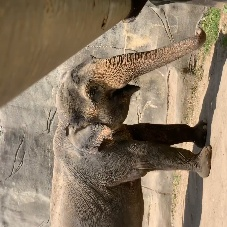

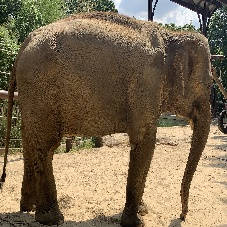

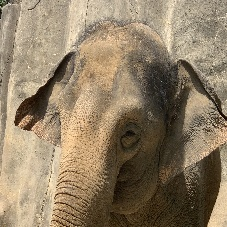

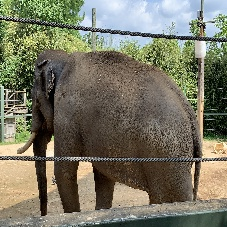

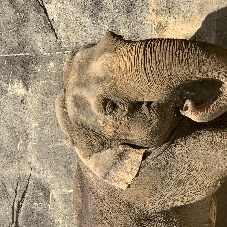

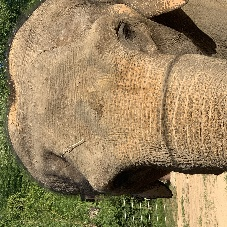

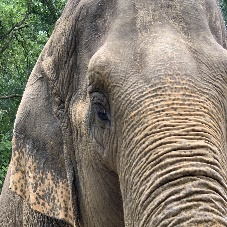

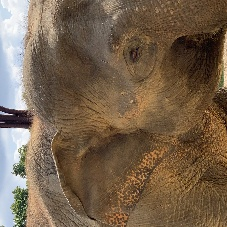

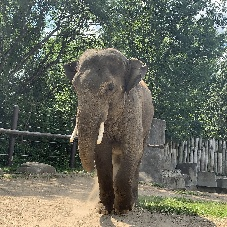

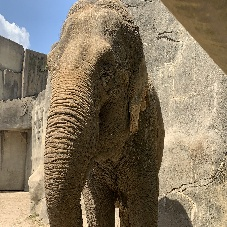

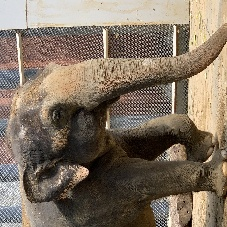

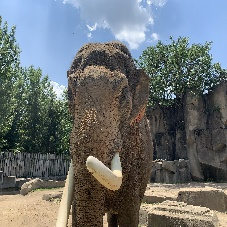

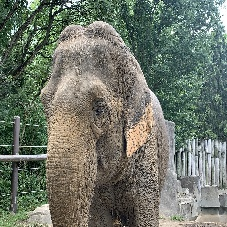

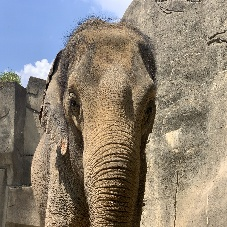

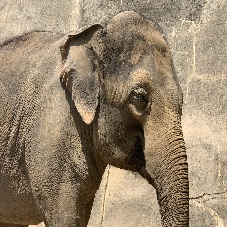

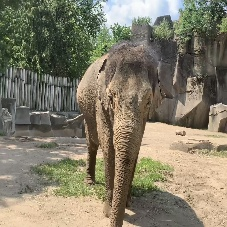

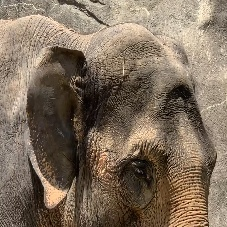

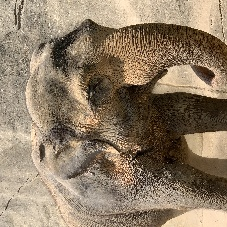

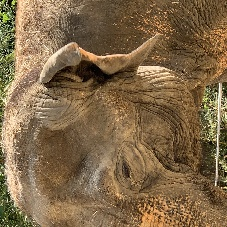

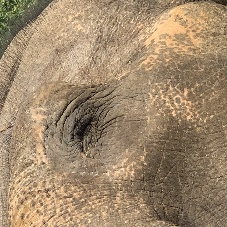

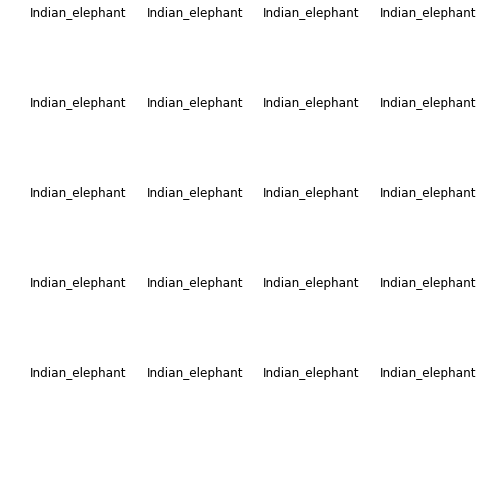

In [79]:
display_grid_images(correct_imagepaths.values.astype(str),correct_labels)

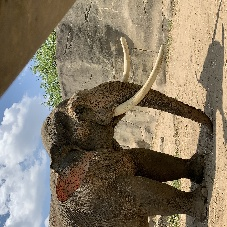

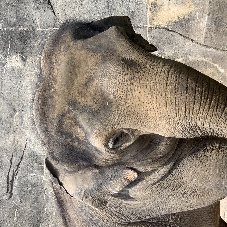

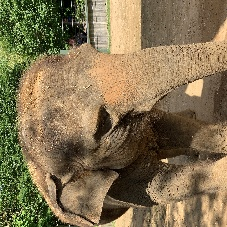

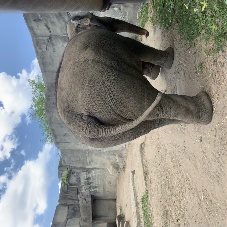

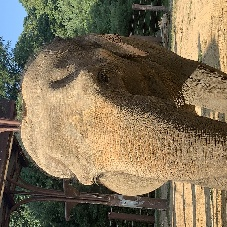

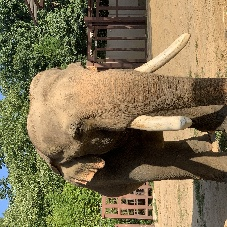

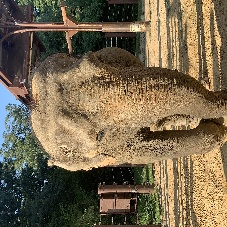

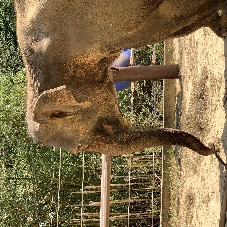

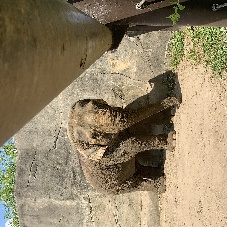

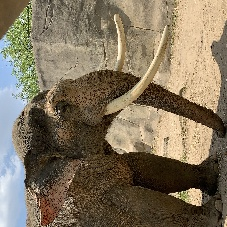

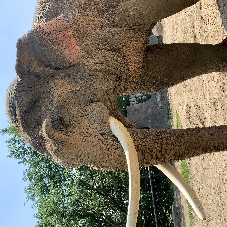

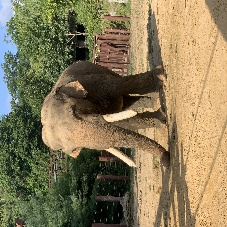

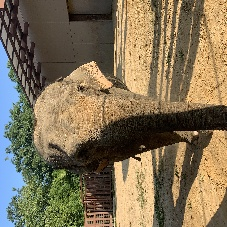

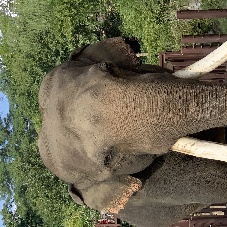

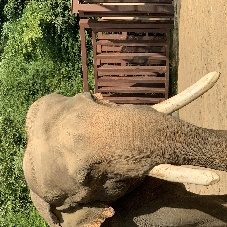

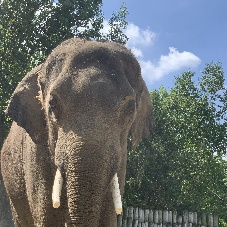

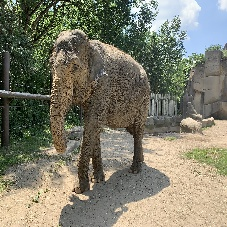

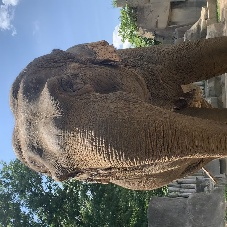

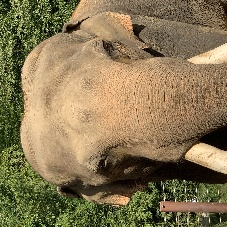

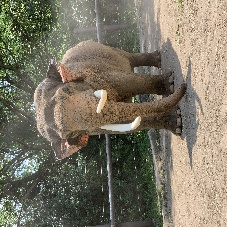

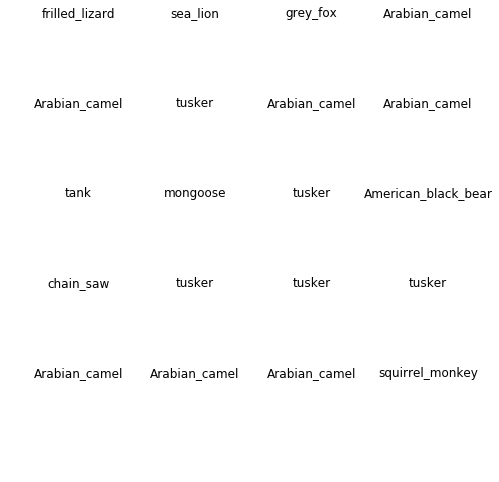

In [80]:
display_grid_images(incorrect_imagepaths.values.astype(str),incorrect_labels)